# Interferon beta stim and genetic perturbations cause changes in gene-gene correlation

Demonstrating differential expression between cell types and the effect of interferon stimulation within a cell type (CD4 T cells).

In [267]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import scipy as sp
import itertools
import numpy as np
import scipy.stats as stats
from scipy.integrate import dblquad
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection
import imp
pd.options.display.max_rows = 999
pd.set_option('display.max_colwidth', -1)
import pickle as pkl
import time

In [268]:
%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [269]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'figure.titlesize':'xx-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)


In [270]:
import warnings
warnings.filterwarnings('ignore')

In [271]:
from sklearn.decomposition import PCA

In [272]:
from sklearn.preprocessing import StandardScaler

In [273]:
import sys
sys.path.append('/home/mkim7/Github/scrna-parameter-estimation/simplesc')
import scme, utils

In [274]:
data_path = '/data/parameter_estimation/'

### Plotting function

In [275]:
def plot_2d_discrete(data, size_multiplier=10, offset=0.0):
    """ Plotting discrete 2D data according to the frequency. """
    
    df = pd.DataFrame(data).groupby([0, 1]).size().reset_index(name='count')
    df['log_count'] = np.log(df['count'])
    
    plt.scatter(df[0]+offset, df[1]+offset, s=df['log_count']*size_multiplier)    
    

### Read the IFN AnnData object

In [276]:
ifn_adata = sc.read(data_path + 'interferon_data/interferon.raw.h5ad')
ifn_adata = ifn_adata[:, ifn_adata.var.index.map(lambda x: x[:2] != 'HB')]
ifn_adata.obs['cell_type'] = (ifn_adata.obs['cell'].astype(str) + ' - ' + ifn_adata.obs['stim'].astype(str)).astype('category')

Trying to set attribute `.obs` of view, making a copy.


### Read CD4 AnnData object

In [277]:
cd4_adata = sc.read(data_path + 'cd4_cropseq_data/guide_singlets.h5ad')

### Figure out which genes to test for correlation using CD4 data

Only pick genes that have > 10% cells expressing the gene

In [565]:
cd4_adata.obs['target_regulator'] = cd4_adata.obs['guide1_cov'].apply(lambda x: x.split('.')[0])

In [566]:
ko_genes = cd4_adata.obs['target_regulator']

In [567]:
# Filter for genes in the IFN dataset
genes_to_test = list(set(ifn_adata.var.index.tolist()) & set(cd4_adata.obs['target_regulator'].tolist()))

In [568]:
# Read the immune genes we filtered previously
with open(data_path + 'interferon_data/immune_genes.pkl', 'rb') as f:
    immune_genes = pkl.load(f)

In [569]:
# Pick genes that have a fairly high expression
ko_gene_to_test = [gene for gene in genes_to_test if (cd4_adata[:, gene].X > 0).sum() / cd4_adata.shape[0] > 0.1]
immune_gene_to_test = [gene for gene in immune_genes if (cd4_adata[:, gene].X > 0).sum() / cd4_adata.shape[0] > 0.1]

In [570]:
with open(data_path + 'interferon_data/immune_genes_to_test.pkl', 'wb') as f:
    pkl.dump(immune_gene_to_test, f)
with open(data_path + 'cd4_cropseq_data/ko_genes_to_test.pkl', 'wb') as f:
    pkl.dump(ko_gene_to_test, f)

### Function for summarizing DC results

In [771]:
def organize_dc_result(result, adata):
    
    idxs_1 = result['gene_idx_1']
    idxs_2 = result['gene_idx_2']
    
    gene_pair_idx = np.array(list(itertools.product(range(len(idxs_1)), range(len(idxs_2)))))
    
    df = pd.DataFrame(
        data=list(zip(
            adata.var.index[idxs_1[gene_pair_idx[:, 0]]], 
            adata.var.index[idxs_2[gene_pair_idx[:, 1]]],
            result['corr_1'][gene_pair_idx[:, 0], gene_pair_idx[:, 1]],
            result['corr_2'][gene_pair_idx[:, 0], gene_pair_idx[:, 1]],
            result['dc_pval'][gene_pair_idx[:, 0], gene_pair_idx[:, 1]],
            result['dc_fdr'][gene_pair_idx[:, 0], gene_pair_idx[:, 1]])),
        columns=['gene_1', 'gene_2', 'corr_1', 'corr_2', 'pval', 'fdr'])
    
    return df
def organize_1d_result(result, adata):
    
    df = pd.DataFrame()
    df['gene'] = adata.var.index.tolist()
    df['de_diff'] = result['de_diff']
    df['de_pval'] = result['de_pval']
    df['de_fdr'] = result['de_fdr']
    df['dv_pval'] = result['dv_pval']
    df['dv_fdr'] = result['dv_fdr']
    return df

In [772]:
ct = 'CD4 T cells'

In [801]:
with open(data_path + 'interferon_data/stim_effect_1d_moments.pkl', 'rb') as f:
    ifn_moment_dict_1d = pkl.load(f)
with open(data_path + 'interferon_data/stim_effect_2d.pkl', 'rb') as f:
    ifn_dc_result = pkl.load(f)
with open(data_path + 'interferon_data/stim_effect_1d.pkl', 'rb') as f:
    ifn_de_dv_result = pkl.load(f)
with open(data_path + 'interferon_data/stim_effect_ci_2d.pkl', 'rb') as f:
    ifn_corr_ci = pkl.load(f)

In [804]:
ifn_dc_df = organize_dc_result(ifn_dc_result[(ct + ' - ctrl', ct + ' - stim')], ifn_adata)
#ifn_dc_df = ifn_dc_df.query('fdr < 0.2')
ifn_regulators = ifn_dc_df['gene_1'].drop_duplicates().tolist()

### Find examples of DC without DE

In [786]:
ifn_1d_df = organize_1d_result(ifn_de_dv_result[(ct + ' - ctrl', ct + ' - stim')], ifn_adata)
nonsig_1d = ifn_1d_df.query('de_fdr > 0.1')

In [787]:
#ifn_dc_df = ifn_dc_df[ifn_dc_df['gene_1'].isin(nonsig_1d.gene.tolist())]

### Read CD4 2D result

In [895]:
guides = \
"""ARID5B.61902410.pkl
ARID5B.62050979.pkl
ATF4.39521667.pkl
ATF4.39521890.pkl
BATF.75522739.pkl
BATF.75546499.pkl
BCLAF1.136278294.pkl
BCLAF1.136278663.pkl
CEBPZ.37223251.pkl
CEBPZ.37228088.pkl
CREM.35179264.pkl
CREM.35188237.pkl
DCP1A.53292521.pkl
DCP1A.53338096.pkl
DNMT1.10146475.pkl
DNMT1.10162681.pkl
DPF2.65340430.pkl
DPF2.65341049.pkl
ETS1.128486081.pkl
ETS1.128489368.pkl
FOXP1.71015617.pkl
FOXP1.71041428.pkl
FUS.31183999.pkl
FUS.31184329.pkl
HDAC3.141628129.pkl
HDAC3.141634859.pkl
HOPX.56655937.pkl
HOPX.56655984.pkl
ID2.8682335.pkl
ID2.8682404.pkl
IKZF1.50376659.pkl
IKZF1.50399996.pkl
IRF1.132487047.pkl
IRF1.132487119.pkl
KLF6.3781951.pkl
KLF6.3782035.pkl
MATR3.139307613.pkl
MATR3.139308137.pkl
MAZ.29807147.pkl
MAZ.29807312.pkl
MYC.127738837.pkl
MYC.127738942.pkl
NCOA4.46010999.pkl
NCOA4.46012894.pkl
NONO.71294280.pkl
NONO.71296973.pkl
PARP1.226385581.pkl
PARP1.226390562.pkl
PHB2.6969554.pkl
PHB2.6970441.pkl
RBBP7.16857703.pkl
RBBP7.16869108.pkl
SATB1.18415117.pkl
SATB1.18417016.pkl
STAT3.42329588.pkl
STAT3.42333711.pkl
STAT6.57102489.pkl
STAT6.57104558.pkl
TAF7.141319508.pkl
TAF7.141319979.pkl
TFAM.58388232.pkl
TFAM.58388689.pkl
TOX4.21487678.pkl
TOX4.21488845.pkl
XBP1.28797122.pkl
XBP1.28800395.pkl
ZC3H15.186501310.pkl
ZC3H15.186502553.pkl
ZFP36L1.68790062.pkl
ZFP36L1.68790159.pkl
ZNF146.36236488.pkl
ZNF24.35339842.pkl
ZNF24.35340244.pkl
ZNF593.26170086.pkl""".split()

In [896]:
guides = [g[:-4] for g in guides]
cd4_results = {}
cd4_ci = {}
for g in guides:
    
    try:
        cd4_results[g] = pkl.load(open(data_path + 'cd4_cropseq_data/diff_cor/{}.pkl'.format(g), 'rb'))
        cd4_ci[g] = pkl.load(open(data_path + 'cd4_cropseq_data/ko_ci/{}.pkl'.format(g), 'rb'))
    except:
        continue
cd4_df = []
for g, res in cd4_results.items():
    
    df = organize_dc_result(res, cd4_adata)
    df['guide'] = g
    df['target_gene'] = g.split('.')[0]
    cd4_df.append(df)
cd4_df = pd.concat(cd4_df)\
    .query('corr_1 < 1 & corr_1 > -1 & corr_2 < 1 & corr_2 > -1')
cd4_df = cd4_df[cd4_df['target_gene'].isin(ifn_regulators)].query('fdr < 0.2')
cd4_df = cd4_df[cd4_df['corr_1'].abs() > cd4_df['corr_2'].abs()]

In [897]:
cd4_ko_counts = cd4_df\
    .groupby(['gene_1', 'gene_2'])\
    .agg({
        'target_gene':set,
        'corr_1':set,
        'corr_2':set})\
    .reset_index()
cd4_ko_counts['ko_count'] = cd4_ko_counts['target_gene'].apply(len)
cd4_ko_counts = cd4_ko_counts[cd4_ko_counts.apply(lambda row: row['gene_1'] in row['target_gene'], axis=1)]

### Find some interesting cases

Correlation of IRF1 and NKFIA, FOXP1 as mediator


In [898]:
combined_df = ifn_dc_df.merge(cd4_df, on=['gene_1', 'gene_2'], suffixes=('_ifn', '_ko'), how='inner')

In [899]:
combined_df\
    .query('fdr_ifn < 0.2 & fdr_ko < 0.2')\
    .sort_values('corr_1_ko', ascending=False)\
    .query('gene_1 == "BATF"').head(4)

,gene_1,gene_2,corr_1_ifn,corr_2_ifn,pval_ifn,fdr_ifn,corr_1_ko,corr_2_ko,pval_ko,fdr_ko,guide,target_gene
7883,BATF,HSPH1,0.064294,0.396232,0.000003,0.001384,0.487343,0.170754,0.011599,0.111918,FOXP1.71041428,FOXP1
7885,BATF,HSPH1,0.064294,0.396232,0.000003,0.001384,0.487343,0.185352,0.026997,0.195172,STAT6.57102489,STAT6
7884,BATF,HSPH1,0.064294,0.396232,0.000003,0.001384,0.487343,0.058808,0.003200,0.081166,PARP1.226385581,PARP1
7882,BATF,HSPH1,0.064294,0.396232,0.000003,0.001384,0.487343,0.093697,0.006399,0.040268,BATF.75522739,BATF


### Functions for plotting

In [1099]:
def plot_2d_discrete(data, size_multiplier=10, offset=0.0, ax=plt, count_adjust=1, color_order=0):
    """ Plotting discrete 2D data according to the frequency. """
    
    df = pd.DataFrame(data).groupby([0, 1]).size().reset_index(name='count')
    df['proportion'] = df['count']/df['count'].sum()
    df['log_proportion'] = np.log(df['proportion']+1)
    df['adjusted_count'] = df['count']*count_adjust
    df['log_count'] = np.log(df['adjusted_count'])

    ax.scatter(df[0]+offset, df[1]+offset, s=df['log_count']*size_multiplier, color=sns.color_palette()[color_order])    

def line_from_correlation(corr, corr_ci, x, y, mu_x, mu_y, sigma_x, sigma_y, color_order, ax=plt, max_x=15):
    
#     mu_x = x.mean()
#     mu_y = y.mean()
#     sigma_x = x.std()
#     sigma_y = y.std()
    
    beta_up = sigma_y/sigma_x*(corr + corr_ci)
    alpha_up = mu_y - beta_up*mu_x
    
    beta = sigma_y/sigma_x*(corr)
    alpha = mu_y - beta*mu_x
    
    beta_down = sigma_y/sigma_x*(corr - corr_ci)
    alpha_down = mu_y - beta_down*mu_x
    
    x_range = np.arange(x.min(), max_x, 0.1)
    
    up = beta_up*x_range + alpha_up
    line = beta*x_range + alpha
    down = beta_down*x_range + alpha_down
            
    ax.fill_between(x_range, up, down, alpha=0.3, color=sns.color_palette()[color_order])
    ax.plot(x_range, line, color=sns.color_palette()[color_order])

### Plot the KO data

In [1110]:
ifn_adata.var['gene_idx'] = np.arange(ifn_adata.shape[1])
cd4_adata.var['gene_idx'] = np.arange(cd4_adata.shape[1])

genes = ['BATF','HSPH1']
gene_1 = genes[0]
gene_2 = genes[1]

ifn_gene_1_idx = ifn_adata.var.loc[genes[0]]['gene_idx']
ifn_gene_2_idx = ifn_adata.var.loc[genes[1]]['gene_idx']
ifn_gene_1_selected_idx = np.where(ifn_dc_result[('CD4 T cells - ctrl', 'CD4 T cells - stim')]['gene_idx_1'] == ifn_gene_1_idx)[0][0]
ifn_gene_2_selected_idx = np.where(ifn_dc_result[('CD4 T cells - ctrl', 'CD4 T cells - stim')]['gene_idx_2'] == ifn_gene_2_idx)[0][0]

cd4_gene_1_idx = cd4_adata.var.loc[genes[0]]['gene_idx']
cd4_gene_2_idx = cd4_adata.var.loc[genes[1]]['gene_idx']
cd4_gene_1_selected_idx = np.where(cd4_results['ATF4.39521667']['gene_idx_1'] == cd4_gene_1_idx)[0][0]
cd4_gene_2_selected_idx = np.where(cd4_results['ATF4.39521667']['gene_idx_2'] == cd4_gene_2_idx)[0][0]

In [ ]:
%%capture

imp.reload(scme)
estimator = scme.SingleCellEstimator(
    adata=cd4_adata, 
    group_label='group',
    n_umis_column='n_counts',
    num_permute=10000,
    beta=0.1)

print('Estimating beta sq')
estimator.estimate_beta_sq(tolerance=3)
estimator.estimate_parameters()
cd4_1d_moments = estimator.estimated_central_moments.copy()

In [1112]:
def plot_ko(guide, ax=plt, color_order=1):
    sm=6
    ko_data = cd4_adata[cd4_adata.obs.group == guide][:, genes].X.toarray()
    plot_2d_discrete(wt_data, offset=-0.2, ax=ax, size_multiplier=sm)
    plot_2d_discrete(ko_data, offset=0.2, count_adjust=len(wt_data)/len(ko_data), ax=ax, size_multiplier=sm, color_order=color_order)
    
def plot_ko_line(guide, ax=plt, color=1):
    
    wt_data = cd4_adata[cd4_adata.obs.group == 'WT'][:, genes].X.toarray()
    ko_data = cd4_adata[cd4_adata.obs.group == guide][:, genes].X.toarray()
    
    line_from_correlation(
        corr=cd4_results[guide]['corr_1'][cd4_gene_1_selected_idx, cd4_gene_2_selected_idx],
        corr_ci=cd4_ci['BATF.75522739']['WT']['corr'][cd4_gene_1_selected_idx, cd4_gene_2_selected_idx],
        x=wt_data[:, 0],
        y=wt_data[:, 1],
        mu_x=cd4_1d_moments['WT']['first'][cd4_gene_1_idx],
        mu_y=cd4_1d_moments['WT']['first'][cd4_gene_2_idx],
        sigma_x=cd4_1d_moments['WT']['second'][cd4_gene_1_idx],
        sigma_y=cd4_1d_moments['WT']['second'][cd4_gene_2_idx],
        color_order=0,
        ax=ax
        )

    line_from_correlation(
        corr=cd4_results[guide]['corr_2'][cd4_gene_1_selected_idx, cd4_gene_2_selected_idx],
        corr_ci=cd4_ci['BATF.75522739'][guide]['corr'][cd4_gene_1_selected_idx, cd4_gene_2_selected_idx],
        x=ko_data[:, 0],
        y=ko_data[:, 1],
        mu_x=cd4_1d_moments[guide]['first'][cd4_gene_1_idx],
        mu_y=cd4_1d_moments[guide]['first'][cd4_gene_2_idx],
        sigma_x=cd4_1d_moments[guide]['second'][cd4_gene_1_idx],
        sigma_y=cd4_1d_moments[guide]['second'][cd4_gene_2_idx],
        color_order=color,
        ax=ax
        )
    

In [1118]:
import matplotlib.ticker as mticker


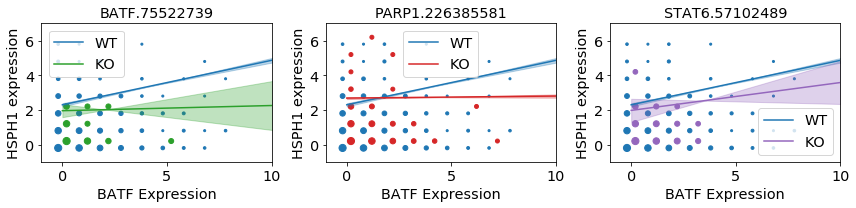

In [1119]:
fig = plt.figure(figsize=(12, 3))
plt.subplots_adjust(hspace=0.0, wspace=0.25)

plt.subplot(1, 3, 1);
plot_ko('BATF.75522739', color_order=2)
plot_ko_line('BATF.75522739', color=2)
plt.xlim(-1, 10)
plt.ylim(-1, 7)
plt.legend(['WT', 'KO'])
plt.title('BATF.75522739')
plt.xlabel('{} Expression'.format(gene_1));
plt.ylabel('{} expression'.format(gene_2));
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(5))

plt.subplot(1, 3, 2);
plot_ko('PARP1.226385581', color_order=3)
plot_ko_line('PARP1.226385581', color=3)
plt.xlim(-1, 10)
plt.ylim(-1, 7)
plt.legend(['WT', 'KO'])
plt.title('PARP1.226385581')
plt.xlabel('{} Expression'.format(gene_1));
plt.ylabel('{} expression'.format(gene_2));
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(5))

plt.subplot(1, 3, 3);
plot_ko('STAT6.57102489', color_order=4)
plot_ko_line('STAT6.57102489', color=4)
plt.xlim(-1, 10)
plt.ylim(-1, 7)
plt.legend(['WT', 'KO'])
plt.title('STAT6.57102489')
plt.xlabel('{} Expression'.format(gene_1));
plt.ylabel('{} expression'.format(gene_2));
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(5))

fig.tight_layout()

fig.savefig(data_path + 'figures/fig3/BATF_HSPH1_KO.pdf')